**This code is taken from Kernel RNN starter for huge time series by MichaelMayer with few modifications**

Modifications :
1. Increased number of features
2. Separate sampling of training and validation set
3. Added data visulation code
4. Changed GRU to LSTM
5. Changing val and train division to 8th earthquake
6. adding dropout and l2 regularizer for regularization
7. Changing data split to 6th earthquake
8. Adding plot model

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


## BASIC IDEA OF THE KERNEL

The data consists of a one dimensional time series x with 600 Mio data points. 
At test time, we will see a time series of length 150'000 to predict the next earthquake.
The idea of this kernel is to randomly sample chunks of length 150'000 from x, derive some
features and use them to update weights of a recurrent neural net with 150'000 / 1000 = 150
time steps. 


In [2]:

import numpy as np 
import pandas as pd
import os
from tqdm import tqdm

# Fix seeds
from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

# Import
%time float_data = pd.read_csv("../input/train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

CPU times: user 2min 8s, sys: 10.4 s, total: 2min 18s
Wall time: 2min 19s


In [3]:
np.shape(float_data)

(629145480, 2)

## Data Visualization

In [4]:
earthquakes = [5656573, 50085877, 104677355, 138772452, 187641819, 218652629, 245829584, 307838916, 338276286, 375377847, 419368879, 461811622, 495800224, 528777114, 585568143, 621985672]

[12. -1.  7. ...  4.  4.  7.]


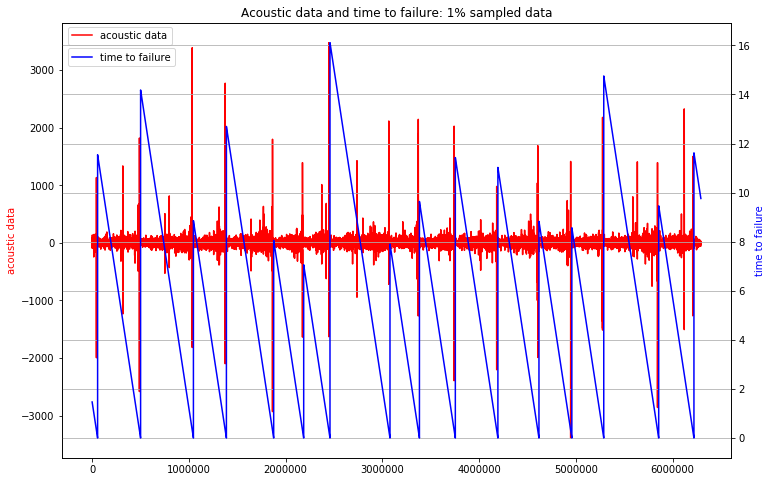

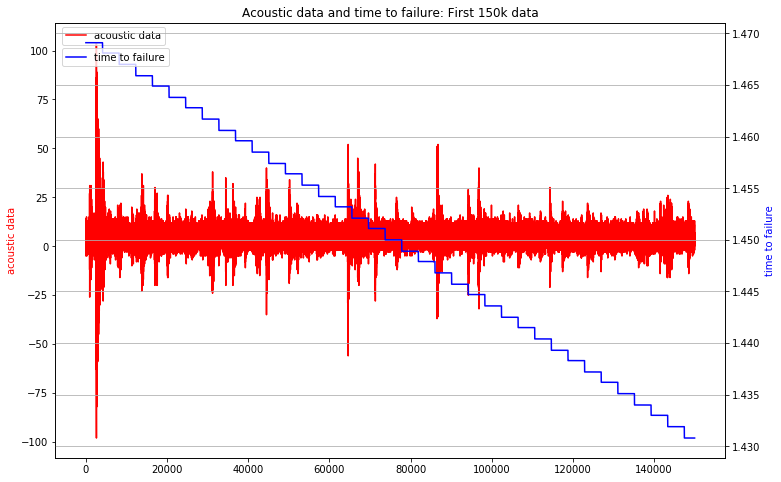

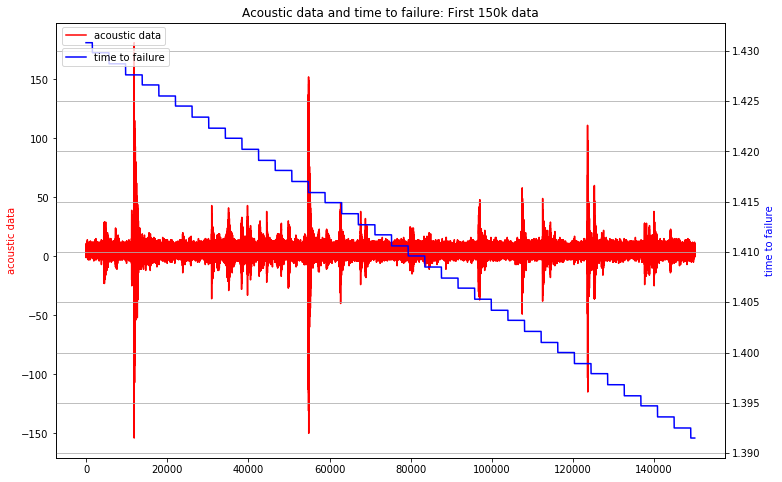

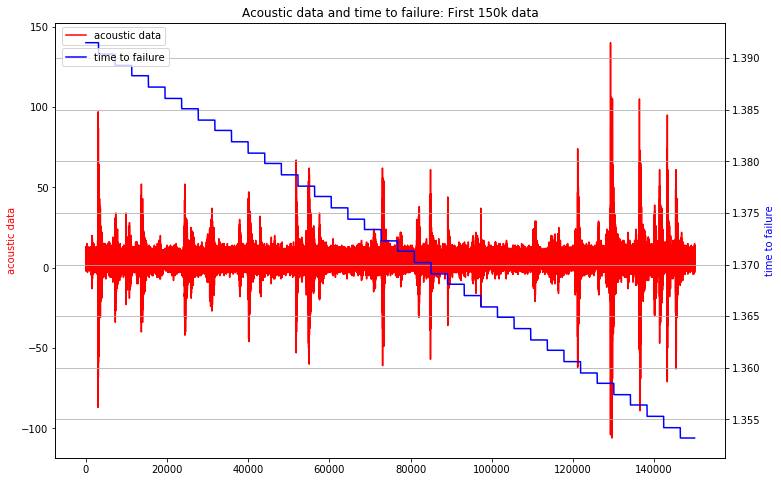

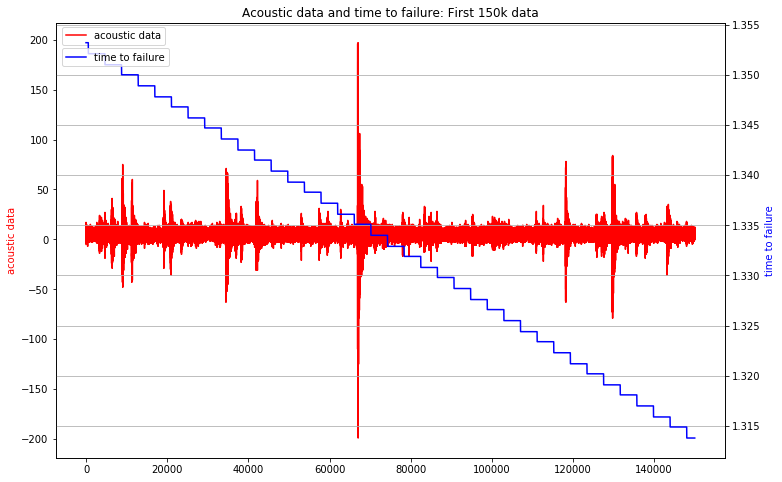

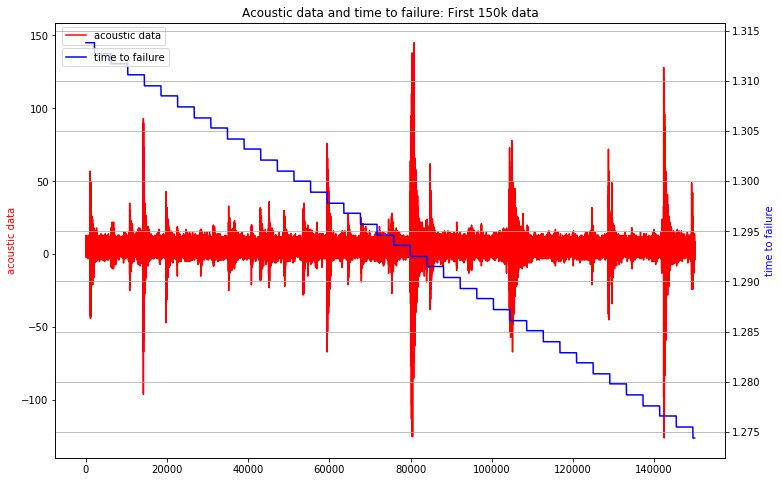

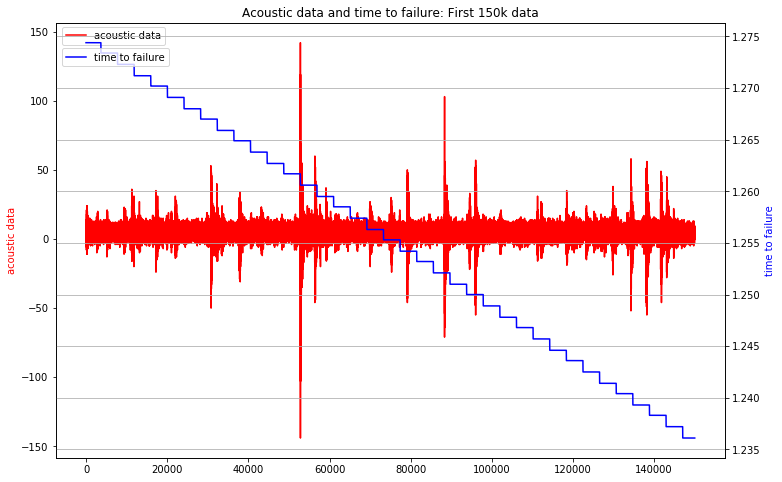

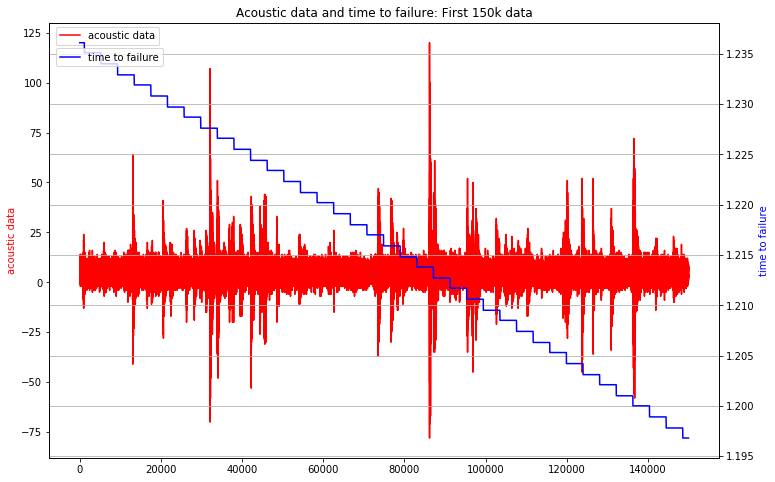

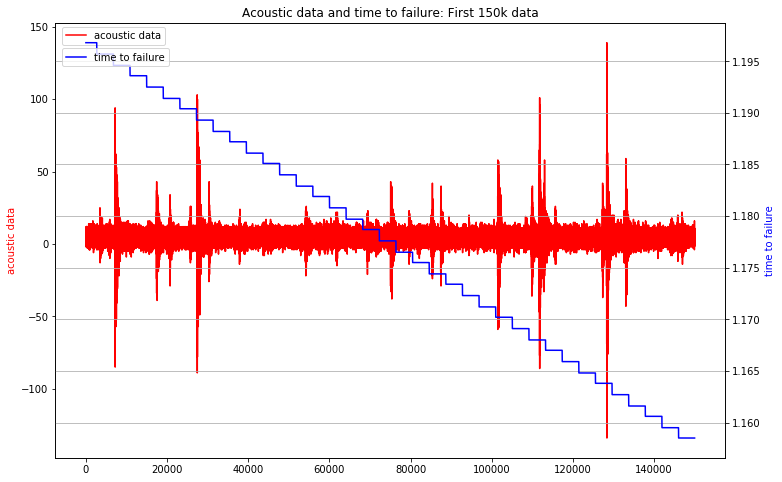

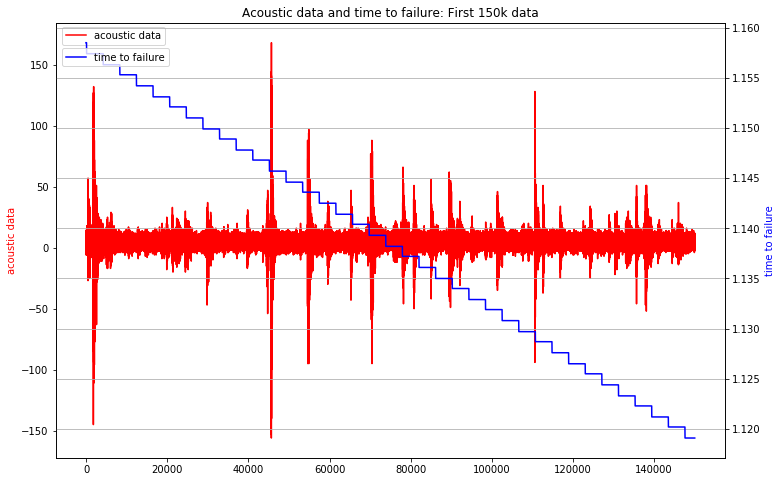

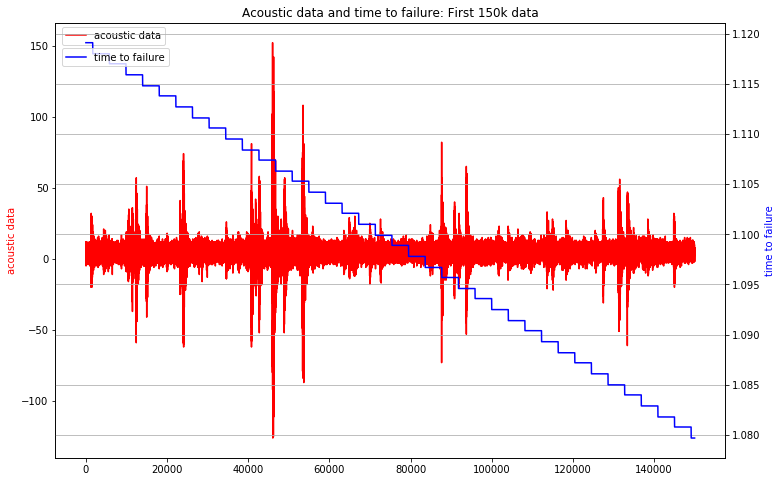

In [5]:
import matplotlib.pyplot as plt
train_ad_sample_df = float_data[:, 0]
train_ad_sample_df = train_ad_sample_df[: : 100]
print(train_ad_sample_df)
train_ttf_sample_df = float_data[:, 1]
train_ttf_sample_df = train_ttf_sample_df[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
for i in range(1 , 1500000, 150000):
    train_ad_sample_df = float_data[i : i + 150000, 0]
    train_ttf_sample_df = float_data[i : i + 150000, 1]
    plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df,  title = "Acoustic data and time to failure: First 150k data")
del train_ad_sample_df
del train_ttf_sample_df


Helper function for the data generator. Extracts mean, standard deviation, and quantiles per time step.
Can easily be extended. Expects a two dimensional array.

In [6]:

def extract_features(z):
     return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1)]


For a given ending position "last_index", we split the last 150'000 values 
of "x" into 150 pieces of length 1000 each. So n_steps * step_length should equal 150'000.
From each piece, a set features are extracted. This results in a feature matrix 
of dimension (150 time steps x features).  

In [7]:

def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 5:]),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 20:]),
                 extract_features(temp[:, -step_length // 25:]),
                 extract_features(temp[:, -step_length // 40:]),
                 extract_features(temp[:, -step_length // 50:]),
                 extract_features(temp[:, -step_length // 100:])]


In [8]:
# Query "create_X" to figure out the number of features
n_features = create_X(float_data[0:150000]).shape[1]
print("Our RNN is based on %i features"% n_features)
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
eighth_eq = earthquakes[7] #307838916
print(float_data[eighth_eq, 1])
print(float_data[eighth_eq, 0])

Our RNN is based on 32 features
0.0006954958
7.0


The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
the "time_to_failure" serves as target, while the features are created by the function "create_X".

In [9]:
def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets

# Initialize generators

In [10]:

#train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
train_gen = generator(float_data, batch_size=batch_size, min_index=earthquakes[5] + 1)
valid_gen = generator(float_data, batch_size=batch_size, max_index=earthquakes[5])

# Define model

In [11]:


from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU, CuDNNLSTM, Dropout
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.utils import plot_model

cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]

model = Sequential()
model.add(CuDNNLSTM(48, input_shape=(None, n_features), kernel_regularizer =regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.summary()
# plot graph of lstm
plot_model(model, show_shapes=True, to_file='model_graph.png')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 48)                15744     
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                490       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 16,245
Trainable params: 16,245
Non-trainable params: 0
_________________________________________________________________



# Compile and fit model

In [12]:


model.compile(optimizer=adam(lr=0.0005), loss="mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=50,
                              verbose=2,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200)


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 72s - loss: 2.9266 - val_loss: 2.3712
Epoch 2/50
 - 66s - loss: 2.4777 - val_loss: 2.2690
Epoch 3/50
 - 67s - loss: 2.3367 - val_loss: 2.2962
Epoch 4/50
 - 65s - loss: 2.3036 - val_loss: 2.3562
Epoch 5/50
 - 67s - loss: 2.2729 - val_loss: 2.3772
Epoch 6/50
 - 66s - loss: 2.2261 - val_loss: 2.3340
Epoch 7/50
 - 66s - loss: 2.2397 - val_loss: 2.1885
Epoch 8/50
 - 67s - loss: 2.1972 - val_loss: 2.2618
Epoch 9/50
 - 66s - loss: 2.1702 - val_loss: 2.3959
Epoch 10/50
 - 67s - loss: 2.1912 - val_loss: 2.3552
Epoch 11/50
 - 66s - loss: 2.1672 - val_loss: 2.3620
Epoch 12/50
 - 67s - loss: 2.1587 - val_loss: 2.2778
Epoch 13/50
 - 66s - loss: 2.1514 - val_loss: 2.3188
Epoch 14/50
 - 66s - loss: 2.1483 - val_loss: 2.2056
Epoch 15/50
 - 68s - loss: 2.1416 - val_loss: 2.3388
Epoch 16/50
 - 65s - loss: 2.1176 - val_loss: 2.1739
Epoch 17/50
 - 67s - loss: 2.1220 - val_loss: 2.2940
Epoch 18/50
 - 66s - loss: 2.1198 - val_loss: 2.1901
Epoch 1


# Visualize accuracies

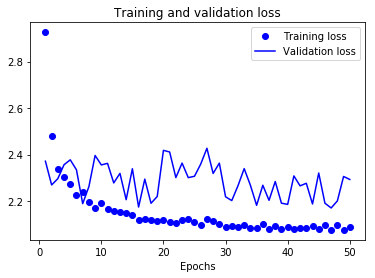

In [13]:

import matplotlib.pyplot as plt

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)


# Load submission file

In [14]:

submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(create_X(x), 0))

submission.head()

# Save
submission.to_csv('submission.csv')

100%|██████████| 2624/2624 [00:50<00:00, 51.94it/s]


## References
1.  https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction
2.  https://www.kaggle.com/mayer79/rnn-starter-for-huge-time-series/
